In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import networkx as nx
import asyncio
import aiohttp
import matplotlib.pyplot as plt
import powerlaw
from collections import Counter


# Fetching the data from the JSON files

In [145]:
import os
import json

# Specify the path to the folder containing JSON files
data_folder_path = '../data/'

# Create an empty dictionary to store data
all_data = {}

# Iterate over all files in the folder
for filename in os.listdir(data_folder_path):
    if filename.endswith(".json"):
        # Form the complete path to the JSON file
        json_file_path = os.path.join(data_folder_path, filename)
        
        # Read the JSON file and store its content in the dictionary
        with open(json_file_path, 'r') as file:
            # Use the filename (without extension) as the key in the dictionary
            all_data[os.path.splitext(filename)[0]] = json.load(file)

# Evolving undirected graph with nodes as characters and weighted edges
For this part, the network to be constructed is of all the characters appearing in all 3 seasons of the Naruto anime. In the following, a function will be defined such that there is a network for each episode with a total of 1013 episodes and hence 1013 graphs. The networks are constructed in such a way, that for the first episode, all the appearing characters will be the nodes in the graph. The links between the nodes, simply represents that the characters appeared in the same episode. The next graph will build upon the first graph, such that for subsequent episodes, if new characters appear, these will be new nodes. These will only link to the characters appearing in the same episode and not for any of the previous characters from the previous graph, if they do not appear for the next episodes. If characters co-occur several times in episodes, a weight of 1 will be added to their edge for each time they co-occur. Hence the resulting graphs are based on co-occurence and therefore quickly become dense and is inevitabely a giant connected component as no character appears by themselves. 

In [146]:
def create_character_interaction_graph(data, season=None, characters_info=None):
    """
    Create a character interaction graph(s) from episode data.

    Parameters:
    - data (dict): Dictionary containing episode data, where keys are season names
                  and values are lists of episode data dictionaries.
    - season (str): If specified, create a character interaction graph for the given season.
                   If None, create graphs for all seasons in the data.
    - characters_info (dict): Dictionary with character attributes to add as node attributes.

    Returns:
    - graph_dict (dict): Dictionary where keys are graph labels (e.g., 'G1') and values
                        are corresponding networkx.Graph instances representing character
                        interaction graphs.
    """

    graph_dict = {} 
    count = 1  

    if season is None:
        for season_name, episodes_data in data.items():
            for i in range(len(episodes_data)):
                G = nx.Graph()  
                characters = episodes_data[i]["Characters"] 

                if count > 1:
                    G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  

                    for edge in graph_dict[f'G{count-1}'].edges(data=True):
                        char1, char2, data = edge
                        weight = data.get('weight', 0)
                        G.add_edge(char1, char2, weight=weight)

                if characters is not None: 
                    G.add_nodes_from(characters)  

                    for char1 in characters:
                        for char2 in characters:
                            if char1 != char2:
                                if G.has_edge(char1, char2):
                                    G[char1][char2]['weight'] += 1
                                else:
                                    G.add_edge(char1, char2, weight=1)

                graph_dict[f'G{count}'] = G  
                count += 1  
    
    else:
        season_data = data[season]  
        graph_dict = {}  
        count = 1  

        for i in range(len(season_data)):
            G = nx.Graph()  
            characters = season_data[i]["Characters"] 

            if count > 1:
                G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  
                
                for edge in graph_dict[f'G{count-1}'].edges(data=True):
                    char1, char2, data = edge
                    weight = data.get('weight', 0)
                    G.add_edge(char1, char2, weight=weight)

            if characters is not None:  
                G.add_nodes_from(characters) 

                for char1 in characters:
                    for char2 in characters:
                        if char1 != char2:
                            if G.has_edge(char1, char2):
                                G[char1][char2]['weight'] += 1
                            else:
                                G.add_edge(char1, char2, weight=1)

            graph_dict[f'G{count}'] = G  
            count += 1 

    if characters_info:
        for key, graph in graph_dict.items():
            add_node_attributes(graph, characters_info)

    return graph_dict


def add_node_attributes(graph, attributes_dict):
    """
    Add node attributes to a graph based on a dictionary.

    Parameters:
    - graph (networkx.Graph): The graph to which attributes will be added.
    - attributes_dict (dict): Dictionary where keys are node names and values are
                              dictionaries containing node attributes.
    """
    
    for node, attributes in attributes_dict.items():
        normalized_node = next((n for n in graph.nodes if node.lower() == n.lower()), None)
        
        if normalized_node:
            graph.nodes[normalized_node].update(attributes)

## Retrieving the 1013 graphs from all the episodes as a dictionary
Some of the characters are provided with an 'information box' which is a table containing some attributes for the characters. These differ for each character along with the amount of attributes are listed. The characters provided with an information box, get the attributes added to their nodes. The nodes are colored according to which village they belong to in the Naruto anime. There is the "Five great nations" which have been chosen to be regarded as the most prominent villages in the series. Hence there are 5 different colors if a character is informed to belong to any of these and otherwise colored grey if they either do not belong to the 5 villages, or have not been provided with a village information.

In [147]:
# The dictionary of the 1013 graphs of all the episodes with the characters as nodes. Attributes are added from their infobox on the fandom page.
graph_dict_all_seasons = create_character_interaction_graph(all_data["episodes_seasons_characters_updated"], characters_info=all_data['characters_infobox'])

In [148]:
all_data['characters_infobox']['Udon Ise']

{'Birthdate': 'April 3',
 'Sex': 'Male',
 'Age': ['Part I: 8', 'Part II: 12'],
 'Height': ['Part I:127.5  cm1.275\xa0m <br />4.183\xa0ft <br />50.197\xa0in <br />',
  'Part II:142.9  cm1.429\xa0m <br />4.688\xa0ft <br />56.26\xa0in <br />',
  'New Era:175.5  cm1.755\xa0m <br />5.758\xa0ft <br />69.094\xa0in <br />'],
 'Weight': ['Part I:26.5  kg58.422\xa0lb <br />'],
 'Blood type': 'O',
 'Affiliation': ['Konohagakure', ''],
 'Team': ['Team Ebisu', 'Team 5(Anime only)'],
 'Rank': 'Ninja RankPart I:Academy StudentPart II:GeninNew Era:Jōnin',
 'Ninja Rank': ['Part I:Academy Student', 'Part II:Genin', 'New Era:Jōnin'],
 'Nature Type': 'Water Release(Anime only)',
 'Additional Information': ['Bouncy Bouncy Technique(Anime only)',
  'Nose Water Tree(Anime only)',
  'Sexy Technique(Anime only)'],
 'Jutsu': 'Bouncy Bouncy Technique(Anime only)Nose Water Tree(Anime only)Sexy Technique(Anime only)'}

In [153]:
# The five great nations
five_great_node_dict = {
    "Konohagakure": "red",  # Set the color for Konohagakure to white
    "Sunagakure": "green",      # Set the color for other villages as needed
    "Kirigakure": "blue",
    "Kumogakure": "yellow",
    "Iwagakure": "#8B4513",
    "default": "black"
}

five_great_edges_dict = {
    "Konohagakure-Konohagakure": "red", 
    "Sunagakure-Sunagakure": "green", 
    "Kirigakure-Kirigakure": "blue", 
    "Kumogakure-Kumogakure": "yellow",
    "Iwagakure-Iwagakure": "#8B4513",
    "default": "gray"
}

id_color_dict = {"Konohagakure": "Red", "Sunagakure": "Green", "Kirigakure": "Blue", "Kumogakure": "Yellow", "Iwagakure": "Brown", "Remaining villages": "Black"}


In [154]:
def color_nodes_by_affiliation(G, node_colors_dict):
    """
    Color nodes in the graph based on their affiliation.

    Parameters:
    - G: NetworkX graph
    - node_colors_dict: Dictionary mapping village names to colors

    Returns:
    - List of node colors
    """
    node_colors = []
    for node in G.nodes:
        affiliation = G.nodes[node].get('Affiliation', [])

        if affiliation:
            for village in affiliation:
                if village in node_colors_dict:
                    node_colors.append(node_colors_dict[village])
                    break  # Stop checking other villages for this node
            else:
                node_colors.append(node_colors_dict["default"])  # Assign default color if no matching village is found
        else:
            node_colors.append(node_colors_dict["default"])

    return node_colors


def color_edges_by_affiliation(G, edge_colors_dict):
    """
    Color edges in the graph based on the affiliation of their nodes.

    Parameters:
    - G: NetworkX graph
    - edge_colors_dict: Dictionary mapping village names to edge colors

    Returns:
    - List of edge colors
    """
    edge_colors = []
    for edge in G.edges:
        node1, node2 = edge
        affiliation1 = G.nodes[node1].get('Affiliation', [])
        affiliation2 = G.nodes[node2].get('Affiliation', [])

        # Check if both nodes have affiliation
        if affiliation1 and affiliation2:
            common_affiliation = set(affiliation1) & set(affiliation2)
            if common_affiliation:
                for village in common_affiliation:
                    edge_key = f"{village}-{village}"
                    if edge_key in edge_colors_dict:
                        edge_colors.append(edge_colors_dict[edge_key])
                        break  # Stop checking other villages for this edge
                else:
                    edge_colors.append(edge_colors_dict["default"])  # Assign default color if no matching village is found
            else:
                edge_colors.append(edge_colors_dict["default"])  # Assign default color if no common affiliation
        else:
            edge_colors.append(edge_colors_dict["default"])  # Assign default color if one or both nodes have no affiliation

    return edge_colors

## Checking for which episode, that there are 'enough' characters introducted, such that the network starts to follow a power law distribution

At 22 episode already, is there enough characters introduced such that from episode 1-22 the degree distribution is in the 'random regime' and afterwards it switches over to an ultra small world regime where the power law exponent is below 3. 

In [7]:
not_power_law = {}

for network in graph_dict_all_seasons:
    degrees_dict = dict(graph_dict_all_seasons[network].degree())
    degree = list(degrees_dict.values())

    degree_fit = powerlaw.Fit(degree)

    degree_exponent = degree_fit.alpha
    if degree_exponent >= 3:
        not_power_law[network] = degree_exponent

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

In [8]:
for network in graph_dict_all_seasons:
    degrees_dict = dict(graph_dict_all_seasons[network].degree())
    degree = list(degrees_dict.values())

    degree_fit = powerlaw.Fit(degree)

    degree_exponent = degree_fit.alpha
    if degree_exponent <= 3:
        print("No longer power-law distribution at episode", network)
        print("The degree exponent is", round(degree_exponent, 4))
        break

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


In [9]:
print("There are, several times when the constructed graphs fail to follow a power law distribution. It occurs", len(not_power_law), "times. \nThis is most likely due to new characters being introduced changing the dynamics and properties of the graphs")
print("The first time the network of characters follow a power law distribution is at episode 23. Hence we look at episode 22 which has", not_power_law["G22"], "for the exponent")

There are, several times when the constructed graphs fail to follow a power law distribution. It occurs 238 times. 
This is most likely due to new characters being introduced changing the dynamics and properties of the graphs
The first time the network of characters follow a power law distribution is at episode 23. Hence we look at episode 22 which has 4.351044840522699 for the exponent


## Drawing the graph from episode 1-22

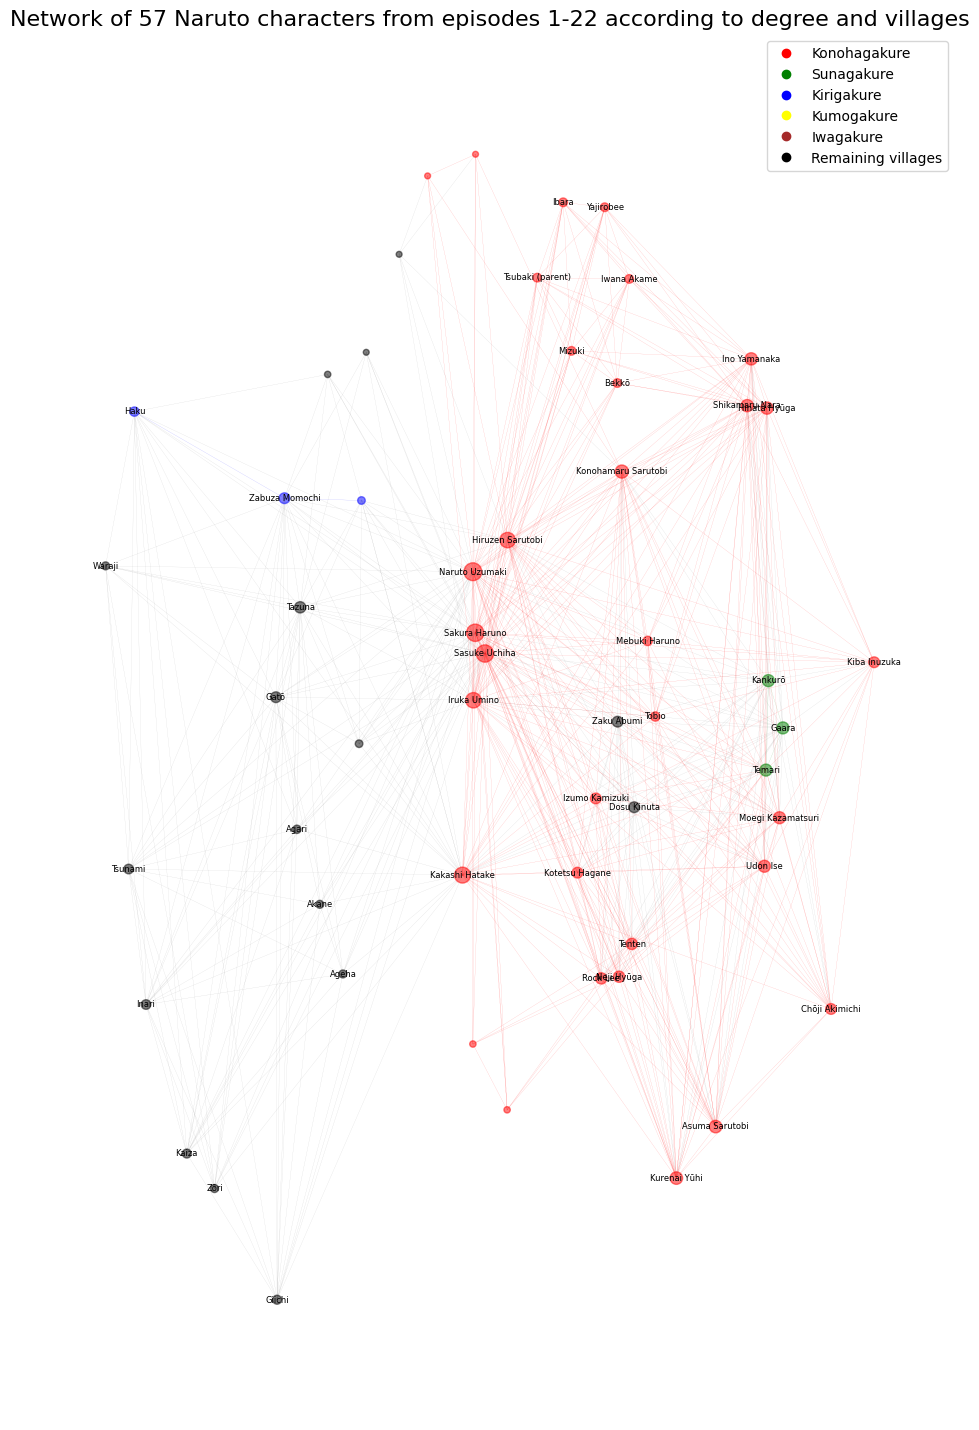

In [155]:
G22 = graph_dict_all_seasons['G22']
degree_dictG22 = dict(G22.degree())

node_colors = color_nodes_by_affiliation(G22, five_great_node_dict)

# Get edge colors
edge_colors = color_edges_by_affiliation(G22, five_great_edges_dict)

# Draw the graph with specified node and edge colors
plt.figure(figsize=(12, 18))

pos = nx.kamada_kawai_layout(G22, scale=8.0)
node_sizes = [v * 3 for v in degree_dictG22.values()]
selected_nodes = [node for node, degree in degree_dictG22.items() if degree > 10]
labels = {node: node for node in selected_nodes}
markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='') for color in id_color_dict.values()]

plt.legend(markers, id_color_dict.keys(), numpoints=1)
plt.title("Network of 57 Naruto characters from episodes 1-22 according to degree and villages", fontsize=16)
nx.draw(G22, pos, node_size=node_sizes, node_color=node_colors, edge_color=edge_colors, width=0.1, alpha=0.5)
nx.draw_networkx_labels(G22, pos, labels, font_size=6)  
plt.show()

100%|██████████| 2000/2000 [00:00<00:00, 4475.67it/s]


BarnesHut Approximation  took  0.07  seconds
Repulsion forces  took  0.29  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


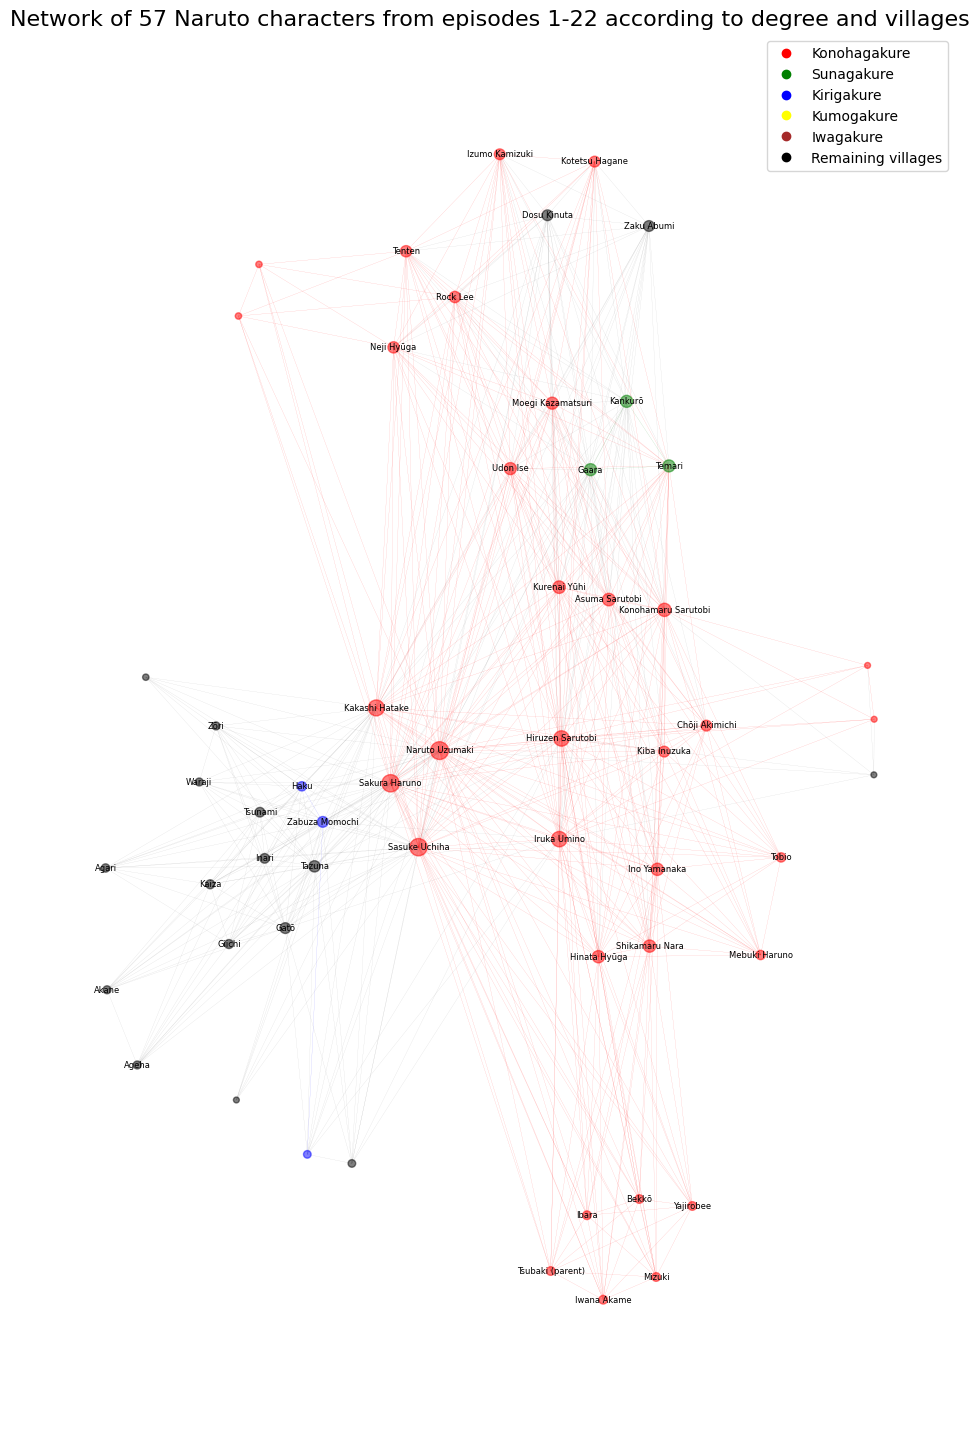

In [156]:
import matplotlib.pyplot as plt
import networkx as nx
from fa2 import ForceAtlas2

# Assuming you have the color_nodes_by_affiliation and color_edges_by_affiliation functions defined

G22 = graph_dict_all_seasons['G22']
degree_dictG22 = dict(G22.degree())

# Get node colors based on affiliation
node_colors = color_nodes_by_affiliation(G22, five_great_node_dict)

# Get edge colors
edge_colors = color_edges_by_affiliation(G22, five_great_edges_dict)

# Draw the graph with specified node and edge colors
plt.figure(figsize=(12, 18))

# Use ForceAtlas2 layout
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=0.001,
    multiThreaded=False,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0
)

# Get ForceAtlas2 layout positions
positions = forceatlas2.forceatlas2_networkx_layout(G22, pos=None, iterations=2000)

node_sizes = [v * 3 for v in degree_dictG22.values()]
selected_nodes = [node for node, degree in degree_dictG22.items() if degree > 10]
labels = {node: node for node in selected_nodes}
markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='') for color in id_color_dict.values()]

plt.legend(markers, id_color_dict.keys(), numpoints=1)
plt.title("Network of 57 Naruto characters from episodes 1-22 according to degree and villages", fontsize=16)
nx.draw(G22, positions, node_size=node_sizes, node_color=node_colors, edge_color=edge_colors, width=0.1, alpha=0.5)
nx.draw_networkx_labels(G22, positions, labels, font_size=6)
plt.show()


## Drawing the graph from episode 1-500
The chosen graph that contains the episodes 1-500 is due to the fact that the network follows a power law distribution which is found to be interesting to showcase the properties of. However, at a few following episodes as for graph 506, the network already fails to follow a power law distribution. It was desired to show a network in the middle of the series, hence episode 1-500 was chosen.

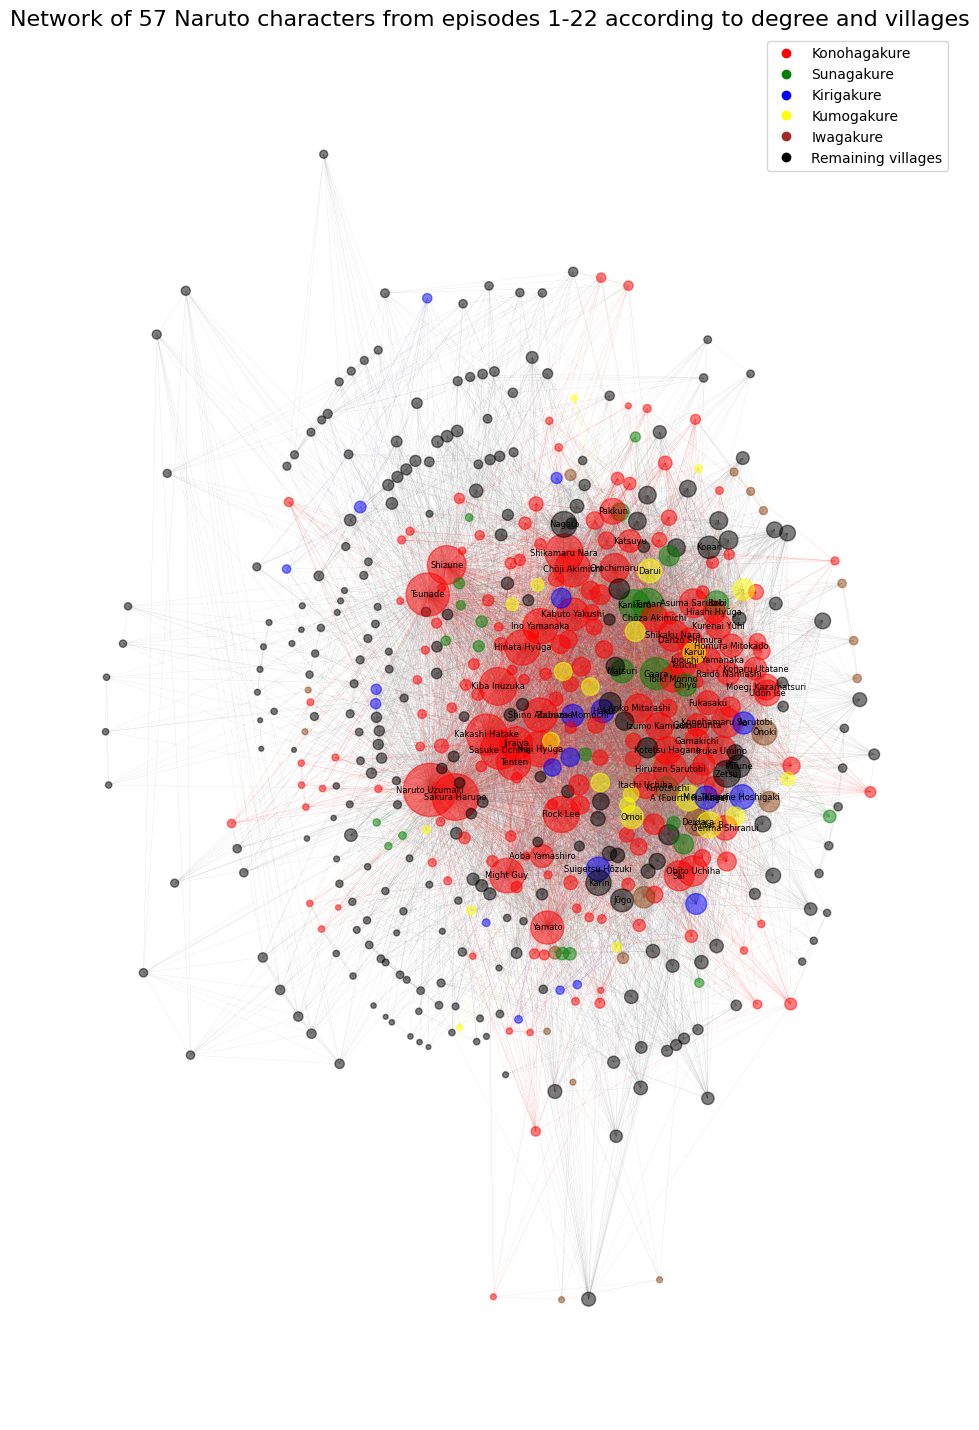

In [157]:
G500 = graph_dict_all_seasons['G500']
degree_dictG500 = dict(G500.degree())

# Get node colors based on affiliation
node_colors = color_nodes_by_affiliation(G500, five_great_node_dict)

# Get edge colors
edge_colors = color_edges_by_affiliation(G500, five_great_edges_dict)

# Draw the graph with specified node and edge colors
plt.figure(figsize=(12, 18))

pos = nx.kamada_kawai_layout(G500, scale=8.0)
node_sizes = [v * 3 for v in degree_dictG500.values()]
average_degree = sum(dict(G500.degree()).values()) / len(G500)
selected_nodes = [node for node, degree in degree_dictG500.items() if degree > average_degree*2]
labels = {node: node for node in selected_nodes}
markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='') for color in id_color_dict.values()]

plt.legend(markers, id_color_dict.keys(), numpoints=1)
plt.title("Network of 57 Naruto characters from episodes 1-22 according to degree and villages", fontsize=16)
nx.draw(G500, pos, node_size=node_sizes, node_color=node_colors, edge_color=edge_colors, width=0.1, alpha=0.5)
nx.draw_networkx_labels(G500, pos, labels, font_size=6)  
plt.show()

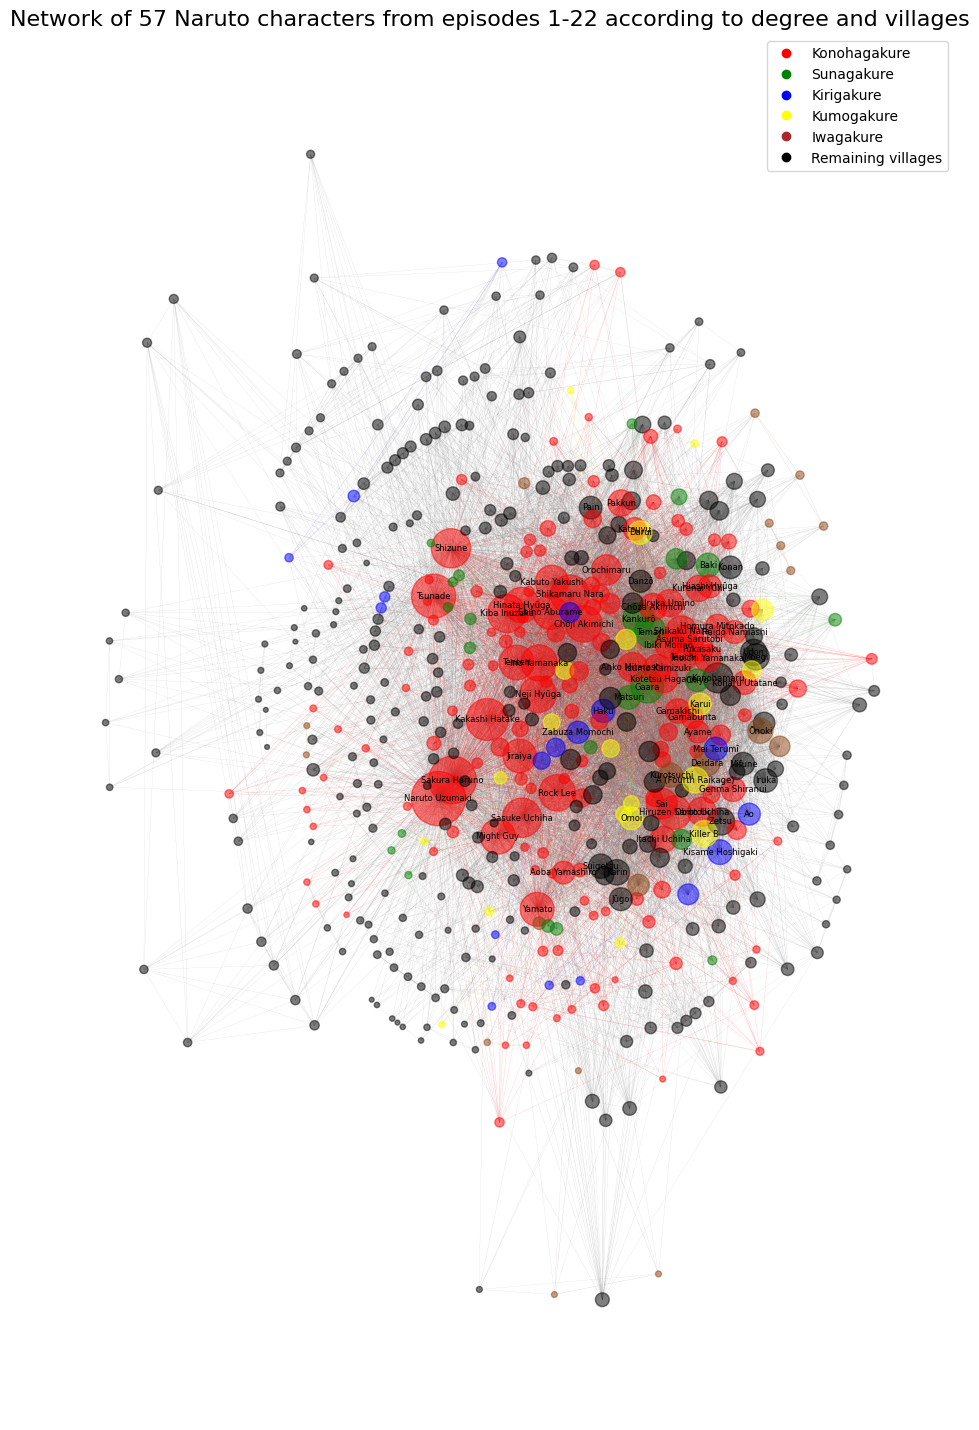

In [37]:
G500 = graph_dict_all_seasons['G500']
degree_dictG500 = dict(G500.degree())

# Get node colors based on affiliation
node_colors = color_nodes_by_affiliation(G500, five_great_node_dict)

# Get edge colors
edge_colors = color_edges_by_affiliation(G500, five_great_edges_dict)

# Draw the graph with specified node and edge colors
plt.figure(figsize=(12, 18))

pos = nx.kamada_kawai_layout(G500, scale=8.0)
node_sizes = [v * 3 for v in degree_dictG500.values()]
average_degree = sum(dict(G500.degree()).values()) / len(G500)
selected_nodes = [node for node, degree in degree_dictG500.items() if degree > average_degree*2]
labels = {node: node for node in selected_nodes}
markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='') for color in id_color_dict.values()]

plt.legend(markers, id_color_dict.keys(), numpoints=1)
plt.title("Network of 57 Naruto characters from episodes 1-22 according to degree and villages", fontsize=16)
nx.draw(G500, pos, node_size=node_sizes, node_color=node_colors, edge_color=edge_colors, width=0.1, alpha=0.5)
nx.draw_networkx_labels(G500, pos, labels, font_size=6)  
plt.show()

100%|██████████| 2000/2000 [00:30<00:00, 65.06it/s]


BarnesHut Approximation  took  3.30  seconds
Repulsion forces  took  26.55  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.24  seconds
AdjustSpeedAndApplyForces step  took  0.20  seconds


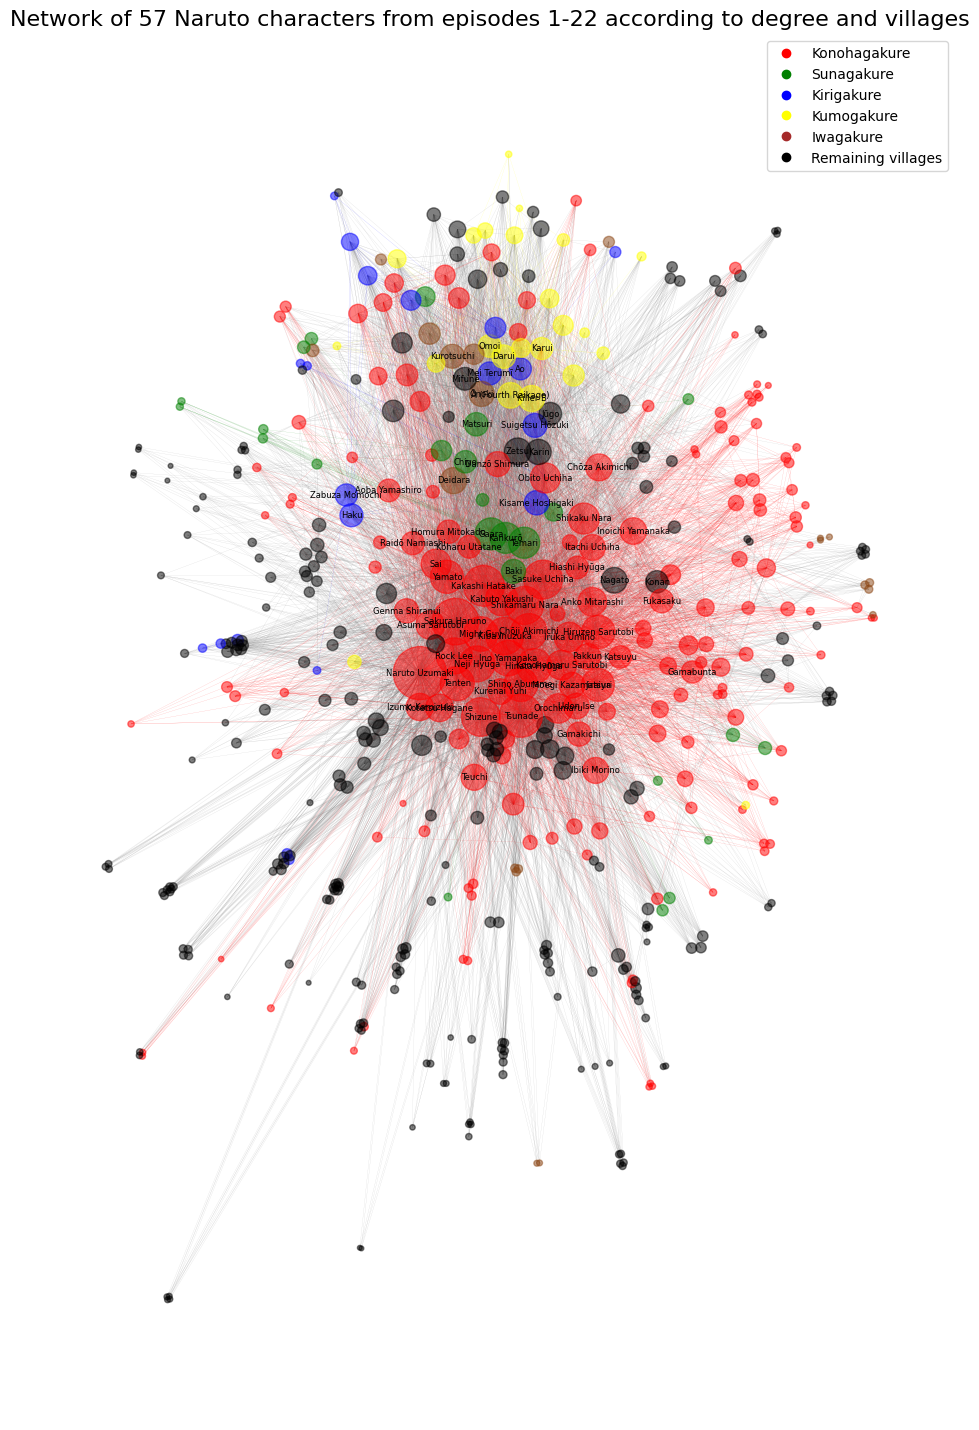

In [159]:
import matplotlib.pyplot as plt
import networkx as nx
from fa2 import ForceAtlas2

# Assuming you have the color_nodes_by_affiliation and color_edges_by_affiliation functions defined

G500 = graph_dict_all_seasons['G500']
degree_dictG500 = dict(G500.degree())

# Get node colors based on affiliation
node_colors = color_nodes_by_affiliation(G500, five_great_node_dict)

# Get edge colors
edge_colors = color_edges_by_affiliation(G500, five_great_edges_dict)

# Draw the graph with specified node and edge colors
plt.figure(figsize=(12, 18))

# Use ForceAtlas2 layout
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=0.5,
    barnesHutOptimize=True,
    barnesHutTheta=0.001,
    multiThreaded=False,
    scalingRatio=20,
    strongGravityMode=False,
    gravity=0.001,
    verbose=True
)

# Get ForceAtlas2 layout positions
positions = forceatlas2.forceatlas2_networkx_layout(G500, pos=None, iterations=2000)

node_sizes = [v * 3 for v in degree_dictG500.values()]
average_degree = sum(dict(G500.degree()).values()) / len(G500)
selected_nodes = [node for node, degree in degree_dictG500.items() if degree > average_degree * 2]
labels = {node: node for node in selected_nodes}
markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='') for color in id_color_dict.values()]

plt.legend(markers, id_color_dict.keys(), numpoints=1)
plt.title("Network of 57 Naruto characters from episodes 1-22 according to degree and villages", fontsize=16)
nx.draw(G500, positions, node_size=node_sizes, node_color=node_colors, edge_color=edge_colors, width=0.1, alpha=0.5)
nx.draw_networkx_labels(G500, positions, labels, font_size=6)
plt.show()


## Drawing the resulting graph of all 1013 episodes

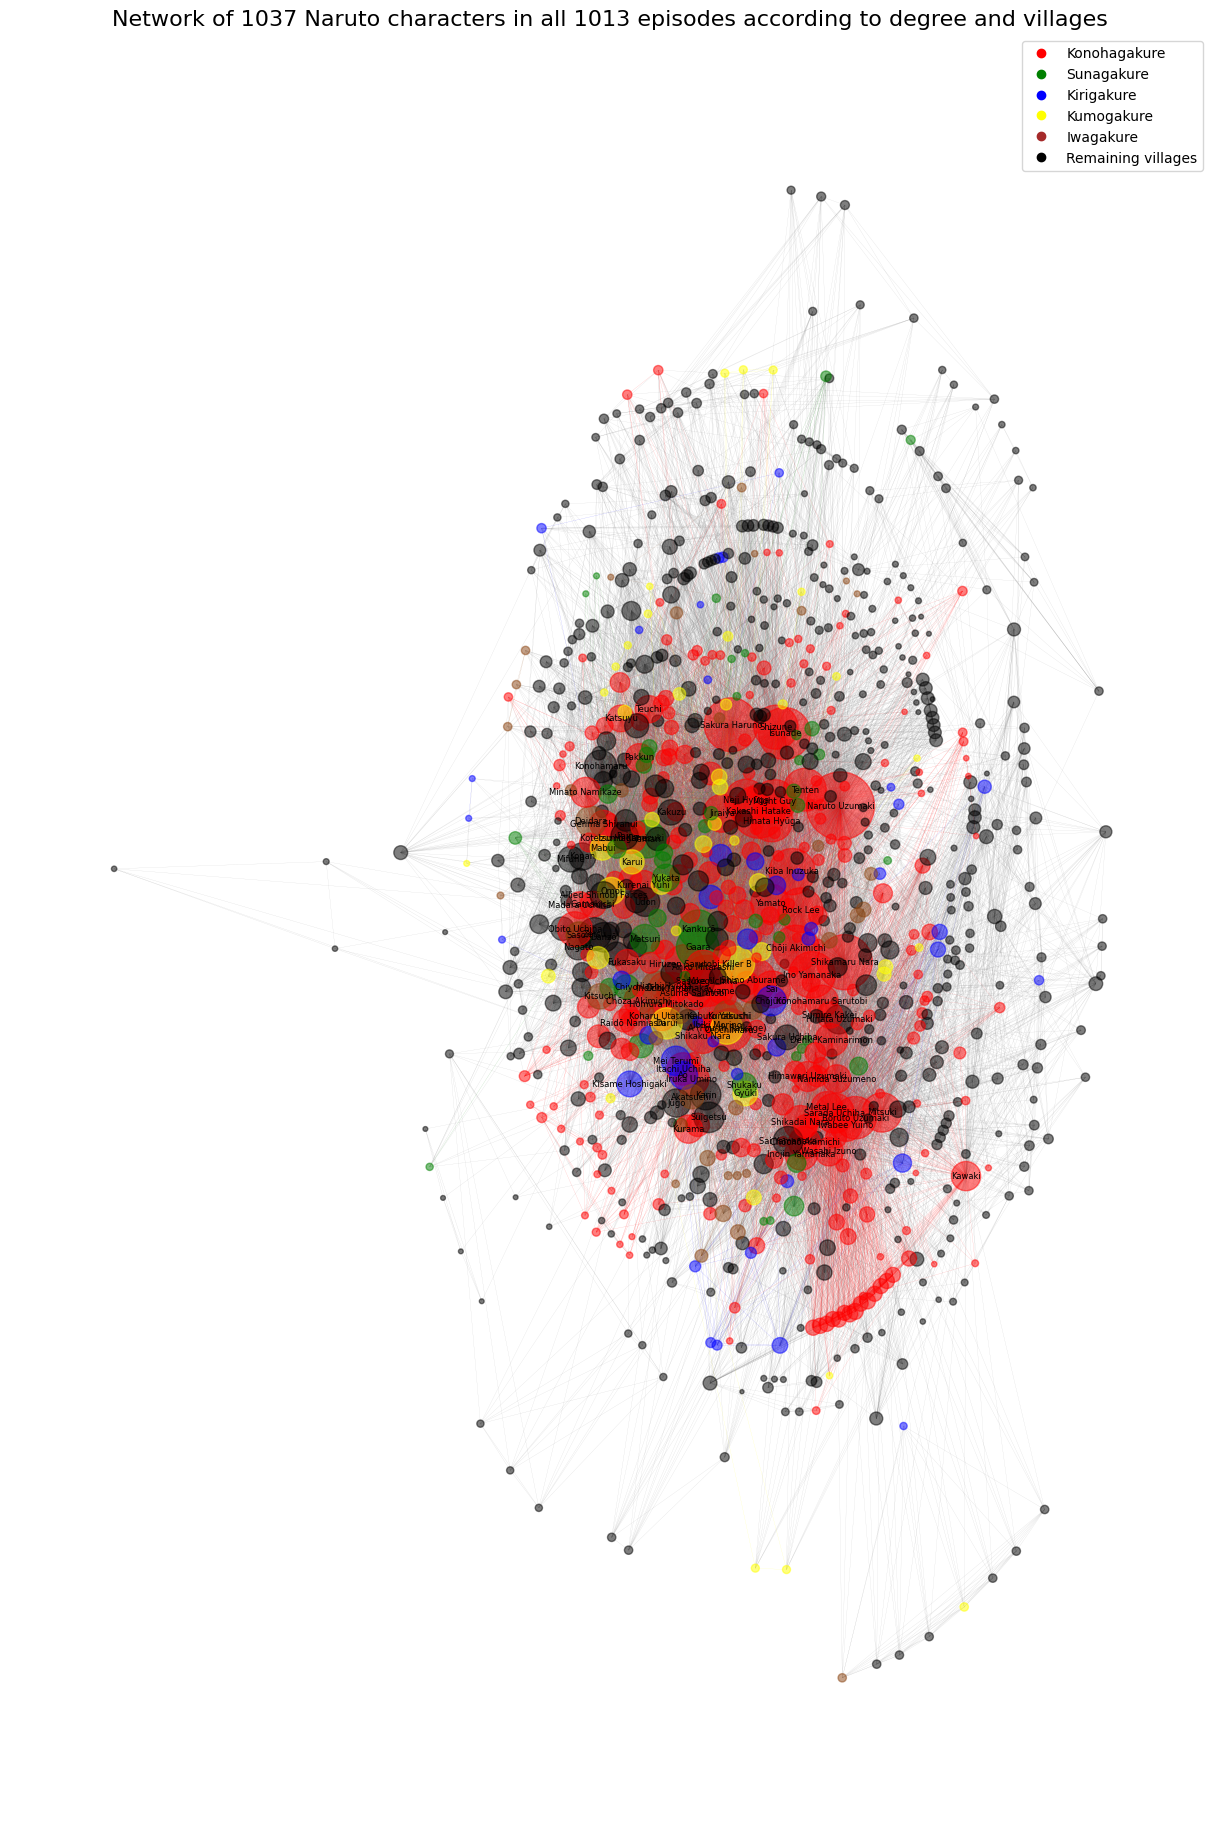

In [57]:
G1 = graph_dict_all_seasons['G1013']
degree_dictG1 = dict(G1.degree())

# Get node colors based on affiliation
node_colors = color_nodes_by_affiliation(G1, five_great_node_dict)

# Get edge colors
edge_colors = color_edges_by_affiliation(G1, five_great_edges_dict)

# Draw the graph with specified node and edge colors
plt.figure(figsize=(12, 18))
pos = nx.kamada_kawai_layout(G1, scale=8.0)
node_sizes = [v * 3 for v in degree_dictG1.values()]
selected_nodes = [node for node, degree in degree_dictG1.items() if degree > 100]

markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='') for color in id_color_dict.values()]

nx.draw(G1, pos, node_size=node_sizes, node_color=node_colors, edge_color=edge_colors, width=0.1, alpha=0.5)
nx.draw_networkx_labels(G1, pos, {node: node for node in selected_nodes}, font_size=6)
plt.legend(markers, id_color_dict.keys(), numpoints=1)
plt.title("Network of 1037 Naruto characters in all 1013 episodes according to degree and villages", fontsize=16)
plt.show()

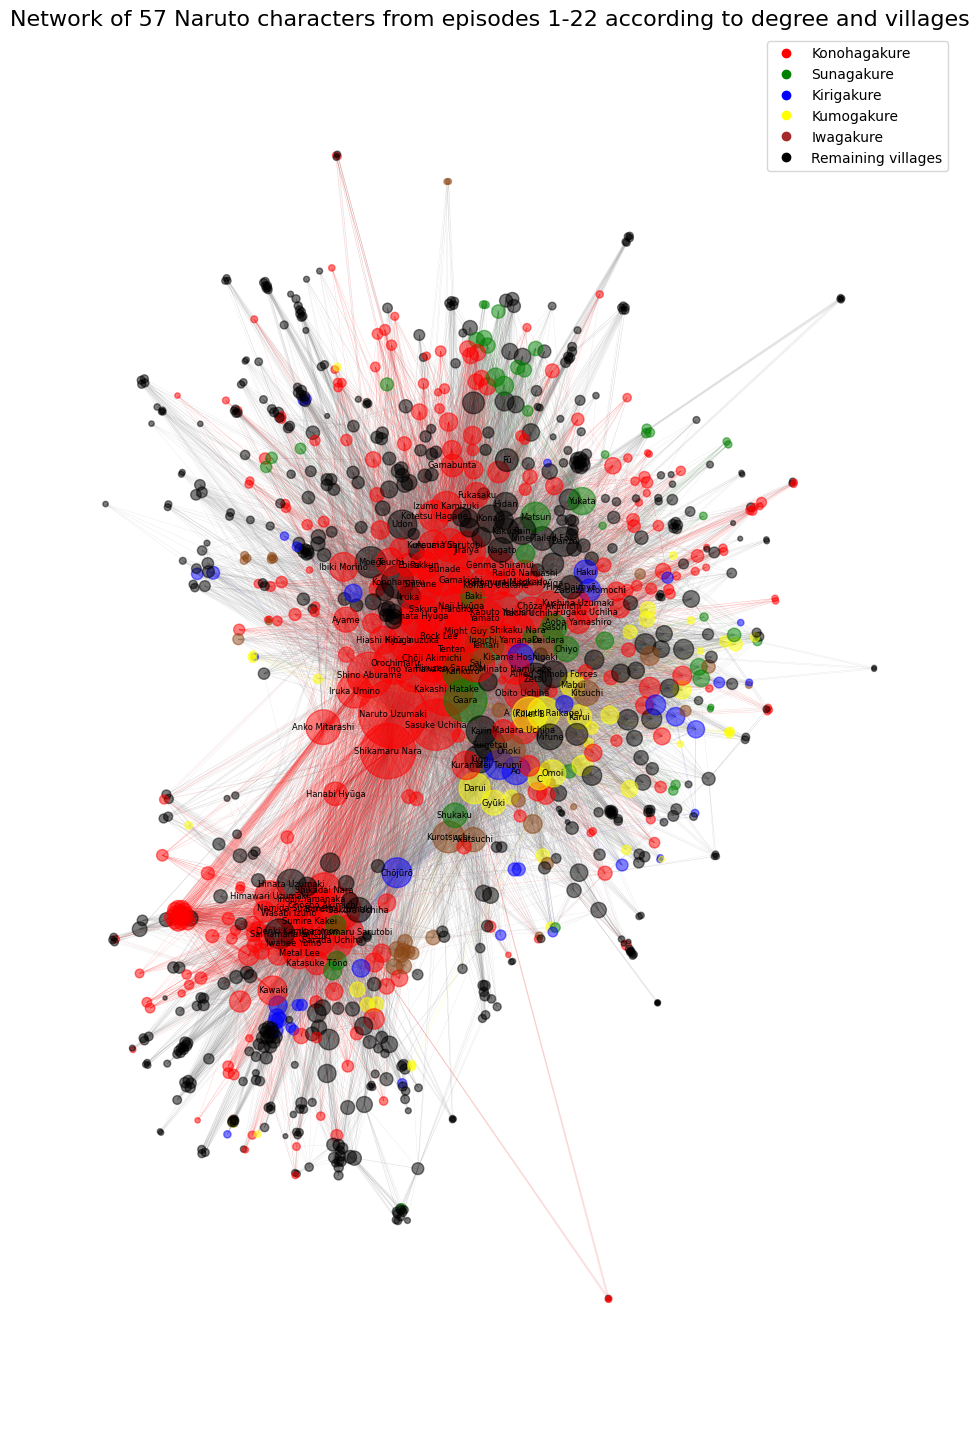

In [58]:
import matplotlib.pyplot as plt
import networkx as nx
from fa2 import ForceAtlas2

# Assuming you have the color_nodes_by_affiliation and color_edges_by_affiliation functions defined

G500 = graph_dict_all_seasons['G500']
degree_dictG500 = dict(G1.degree())

# Get node colors based on affiliation
node_colors = color_nodes_by_affiliation(G1, five_great_node_dict)

# Get edge colors
edge_colors = color_edges_by_affiliation(G1, five_great_edges_dict)

# Draw the graph with specified node and edge colors
plt.figure(figsize=(12, 18))

# Use ForceAtlas2 layout
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=0.5,
    barnesHutOptimize=True,
    barnesHutTheta=0.001,
    multiThreaded=False,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=70.0,
    verbose=False
)

# Get ForceAtlas2 layout positions
positions = forceatlas2.forceatlas2_networkx_layout(G1, pos=None, iterations=2000)

node_sizes = [v * 3 for v in degree_dictG500.values()]
average_degree = sum(dict(G1.degree()).values()) / len(G1)
selected_nodes = [node for node, degree in degree_dictG500.items() if degree > average_degree * 2]
labels = {node: node for node in selected_nodes}
markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='') for color in id_color_dict.values()]

plt.legend(markers, id_color_dict.keys(), numpoints=1)
plt.title("Network of 57 Naruto characters from episodes 1-22 according to degree and villages", fontsize=16)
nx.draw(G1, positions, node_size=node_sizes, node_color=node_colors, edge_color=edge_colors, width=0.1, alpha=0.5)
nx.draw_networkx_labels(G1, positions, labels, font_size=6)
plt.show()


# Network properties and statistics

Here, a function is defined to get the degree distribution for a network. This is done in order to plot a network's respective degree distribution as a histogram and as a loglog plot.

In [44]:
def degree_distribution(graph_dict_all_seasons, episode):
    # Getting the graph from the episode and dictionary
    key = f'G{episode}'
    G = graph_dict_all_seasons[key]

    degrees = list(dict(G.degree()).values()) # Getting the degrees

    # Defining the values for the loglog plot for the degrees
    # Allocating list for the frequency/count of each degree
    frequency = []

    # Making a list of the unique degrees values in the network
    deg_unique = np.unique(degrees)

    # Counting the frequency for each degree
    for degree in deg_unique:
        count = degrees.count(degree)
        frequency.append(count)

    return degrees, frequency, deg_unique

In [45]:
# Getting the degrees and the frequencies for the 3 graphs from episode 1-22 (G22), episode 1-500 (G500) and episode 1-1037 (G1037)
degrees20, frequency20, deg_unique20 = degree_distribution(graph_dict_all_seasons, 22)
degrees500, frequency500, deg_unique500 = degree_distribution(graph_dict_all_seasons, 500)
degrees1013, frequency1013, deg_unique1013 = degree_distribution(graph_dict_all_seasons, 1013)

In [59]:
# Getting the power law exponent for each network
degree_fit20 = powerlaw.Fit(degrees20)
degree_fit500 = powerlaw.Fit(degrees500)
degree_fit1013 = powerlaw.Fit(degrees1013)

degree_exponent20 = round(degree_fit20.alpha,3)
degree_exponent500 = round(degree_fit500.alpha,3)
degree_exponent1013 = round(degree_fit1013.alpha,3)


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


In [50]:
# Setting the limits for the axis of the distribution plot
# x-axis
min_x_lim = -5
max_x_lim = max(degrees1013)

# y-axis
min_y_lim = 0
max_y_lim = max(frequency1013)

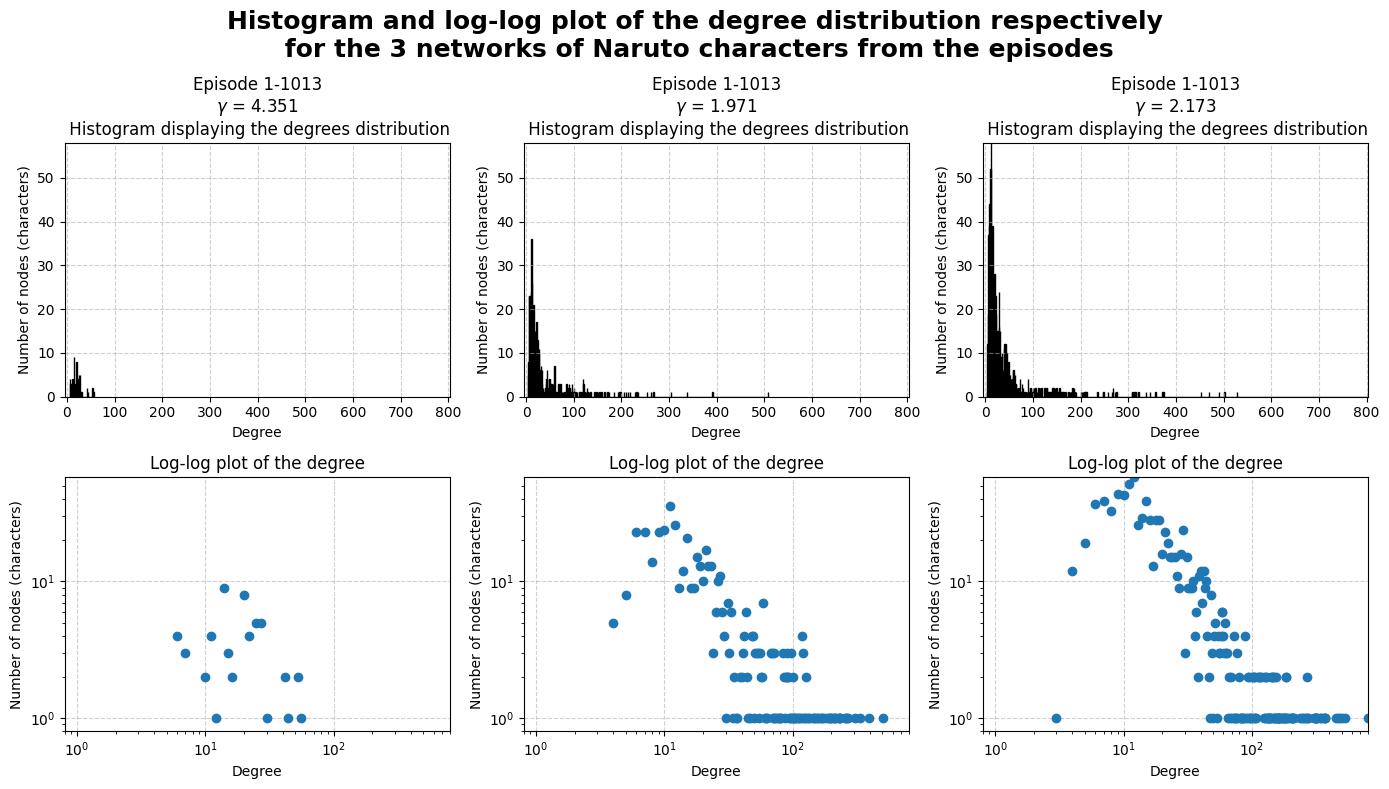

In [66]:
plt.figure(figsize=(14, 8))
############################################## For the histograms ##########################################################
# Histogram of episode 1-22
plt.subplot(2, 3, 1)
plt.hist(degrees20, bins = range(min(degrees20), max(degrees20) + 1,1), edgecolor = 'black')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(min_x_lim, max_x_lim)
plt.ylim(min_y_lim, max_y_lim)
plt.title(f"Episode 1-1013\n$\gamma$ = {degree_exponent20}\n Histogram displaying the degrees distribution")
plt.xlabel("Degree")
plt.ylabel("Number of nodes (characters)")

# Histogram of episode 1-500
plt.subplot(2, 3, 2)
plt.hist(degrees500, bins = range(min(degrees500), max(degrees500) + 1,1), edgecolor = 'black')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(min_x_lim, max_x_lim)
plt.ylim(min_y_lim, max_y_lim)
plt.title(f"Episode 1-1013\n$\gamma$ = {degree_exponent500}\n Histogram displaying the degrees distribution")
plt.xlabel("Degree")
plt.ylabel("Number of nodes (characters)")

# Histogram of episode 1-1013
plt.subplot(2, 3, 3)
plt.hist(degrees1013, bins = range(min(degrees1013), max(degrees1013) + 1,1), edgecolor = 'black')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(min_x_lim, max_x_lim)
plt.ylim(min_y_lim, max_y_lim)
plt.title(f"Episode 1-1013\n$\gamma$ = {degree_exponent1013}\n Histogram displaying the degrees distribution")
plt.xlabel("Degree")
plt.ylabel("Number of nodes (characters)")

############################################## For the loglog plot ##########################################################
# For episode 1-22
plt.subplot(2, 3, 4)
plt.loglog(deg_unique20, frequency20, 'o')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(0.8, max_x_lim)
plt.ylim(0.8, max_y_lim)
plt.title("Log-log plot of the degree")
plt.xlabel("Degree")
plt.ylabel("Number of nodes (characters)")

# For episode 1-500
plt.subplot(2, 3, 5)
plt.loglog(deg_unique500, frequency500, 'o')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(0.8, max_x_lim)
plt.ylim(0.8, max_y_lim)
plt.title("Log-log plot of the degree")
plt.xlabel("Degree")
plt.ylabel("Number of nodes (characters)")

# For episode 1-1013
plt.subplot(2, 3, 6)
plt.loglog(deg_unique1013, frequency1013, 'o')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.xlim(0.8, max_x_lim)
plt.ylim(0.8, max_y_lim)
plt.title("Log-log plot of the degree")
plt.xlabel("Degree")
plt.ylabel("Number of nodes (characters)")

plt.suptitle("Histogram and log-log plot of the degree distribution respectively\n for the 3 networks of Naruto characters from the episodes", fontsize = 18, fontweight='bold')
plt.tight_layout()

## The development of the degree centrality for 10 selected characters
It was found to be interesting to select 10 characters and see how some of them may become more or less influential/connected to the nodes as the series evolve and new characters are introduced. 

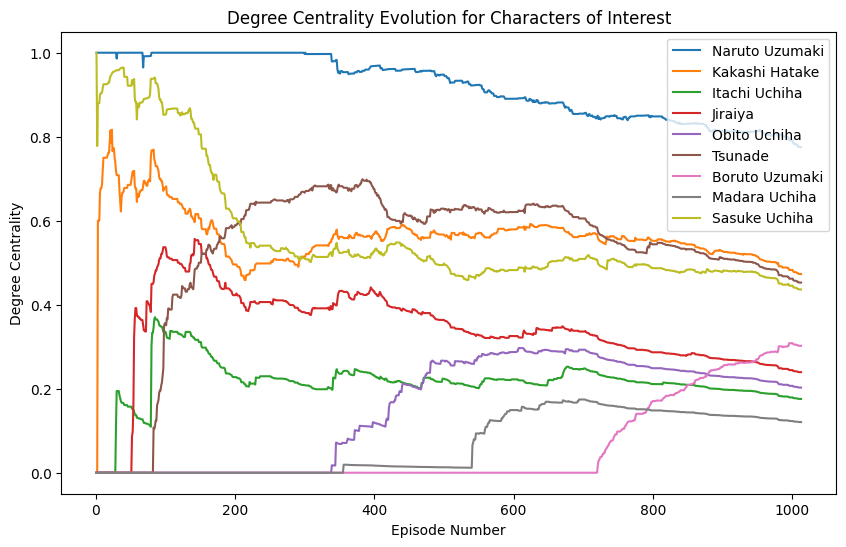

In [93]:
# Assume you have a list of characters you're interested in
characters_of_interest = ["Naruto Uzumaki", "Kakashi Hatake", "Itachi Uchiha", "Jiraiya", "Obito Uchiha", "Tsunade", "Boruto Uzumaki", "Madara Uchiha", "Sasuke Uchiha"]

# Create a dictionary to store degree centrality evolution for each character
degree_centrality_evolution = {char: [] for char in characters_of_interest}

# Iterate over episodes (graphs)
for episode_number in range(1, 1014):
    # Assuming your graphs are named G1, G2, ..., G1013 in graph_dict_all_seasons
    graph = graph_dict_all_seasons[f'G{episode_number}']
    
    # Calculate degree centrality for each character
    for char in characters_of_interest:
        # If the character is not in the graph, set degree centrality to 0
        degree_centrality = nx.degree_centrality(graph).get(char, 0)
        
        # Append the degree centrality to the list for the character
        degree_centrality_evolution[char].append(degree_centrality)

# Plot degree centrality evolution for each character
plt.figure(figsize=(10, 6))
for char, values in degree_centrality_evolution.items():
    plt.plot(range(1, 1014), values, label=char)

plt.xlabel("Episode Number")
plt.ylabel("Degree Centrality")
plt.title("Degree Centrality Evolution for Characters of Interest")
plt.legend()
plt.show()